# Part 1: Neural Networks Basics

## Introduction

In this part, you'll implement a simple neural network for EMNIST character recognition. This will help you understand the fundamentals of neural networks, including dense layers, activation functions, and dropout.

## Learning Objectives

- Load and preprocess EMNIST dataset
- Implement a simple neural network with dense layers
- Train and evaluate the model
- Save model and metrics in the correct format

## Setup and Installation

In [1]:
# Install required packages
#%pip install -r requirements.txt

# Import necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Configure matplotlib for better visualization
plt.style.available
plt.style.use('seaborn-v0_8-dark-palette')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Create directories
os.makedirs('models', exist_ok=True)
os.makedirs('results/part_1', exist_ok=True)
os.makedirs('logs', exist_ok=True)

## 1. Data Loading and Preprocessing

Training data shape: (88800, 28, 28, 1)
Test data shape: (14800, 28, 28, 1)
Number of classes: 26


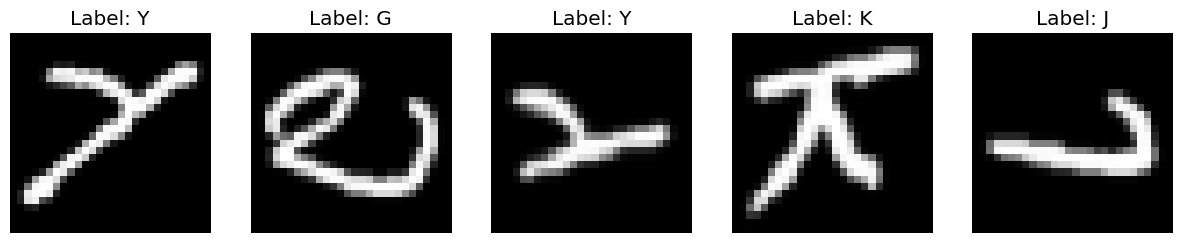

In [2]:
# load the EMNIST dataset
emnist_data = tfds.load('emnist/letters', as_supervised=True)
train_ds, test_ds = emnist_data['train'], emnist_data['test']

# convert to numpy arrays
x_train_list, y_train_list = [], []
for image, label in tfds.as_numpy(train_ds):
    x_train_list.append(image)
    y_train_list.append(label)

x_test_list, y_test_list = [], []
for image, label in tfds.as_numpy(test_ds):
    x_test_list.append(image)
    y_test_list.append(label)

x_train = np.array(x_train_list)
y_train = np.array(y_train_list)
x_test = np.array(x_test_list)
y_test = np.array(y_test_list)

# print dataset information
print(f"Training data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Number of classes: {len(np.unique(y_train))}")

# plot sample images
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_train[i], cmap='gray') 
    plt.title(f'Label: {chr(y_train[i] + 64)}') 
    plt.axis('off')
plt.show()

In [4]:
# Preprocess data
x_train = np.array(x_train_list).astype('float32') / 255.0
y_train = np.array(y_train_list)
x_test = np.array(x_test_list).astype('float32') / 255.0
y_test = np.array(y_test_list)

# Reshape for dense layers
x_train = x_train.reshape(-1, 28 * 28)
x_test = x_test.reshape(-1, 28 * 28)

# One-hot encode the labels (only once)
y_train = tf.keras.utils.to_categorical(y_train - 1, num_classes=26)
y_test = tf.keras.utils.to_categorical(y_test - 1, num_classes=26)

# Split training data into train and validation
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)

# Verify shapes
print(f"Preprocessed training data shape: {x_train.shape}")
print(f"Preprocessed training labels shape: {y_train.shape}")
print(f"Preprocessed validation data shape: {x_val.shape}")
print(f"Preprocessed validation labels shape: {y_val.shape}")
print(f"Preprocessed test data shape: {x_test.shape}")
print(f"Preprocessed test labels shape: {y_test.shape}")

Preprocessed training data shape: (71040, 784)
Preprocessed training labels shape: (71040, 26)
Preprocessed validation data shape: (17760, 784)
Preprocessed validation labels shape: (17760, 26)
Preprocessed test data shape: (14800, 784)
Preprocessed test labels shape: (14800, 26)


## 2. Model Implementation

In [6]:
def create_simple_nn(input_shape, num_classes):
    model = tf.keras.Sequential([
        # Input layer
        tf.keras.layers.Input(shape=input_shape),
        
        # First dense layer with batch normalization and dropout
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        
        # Second dense layer with batch normalization and dropout
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        
        # Third dense layer (optional but helps with complex patterns)
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        
        # Output layer with softmax activation for multi-class classification
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create and compile model
model = create_simple_nn(input_shape=(784,), num_classes=26)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 573,082 (2.19 MB)

 Trainable params: 571,290 (2.18 MB)

 Non-trainable params: 1,792 (7.00 KB)

## 3. Training and Evaluation

Epoch 1/10
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5950 - loss: 1.4180 - val_accuracy: 0.8454 - val_loss: 0.4935
Epoch 2/10
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7972 - loss: 0.6426 - val_accuracy: 0.8635 - val_loss: 0.4246
Epoch 3/10
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8310 - loss: 0.5302 - val_accuracy: 0.8852 - val_loss: 0.3589
Epoch 4/10
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8489 - loss: 0.4689 - val_accuracy: 0.8905 - val_loss: 0.3415
Epoch 5/10
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8576 - loss: 0.4325 - val_accuracy: 0.8966 - val_loss: 0.3201
Epoch 6/10
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8697 - loss: 0.3907 - val_accuracy: 0.9005 - val_loss: 0.3106
Epoch 7/10
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8772 - loss: 0.3689 - val_accuracy: 0.9025 - val_loss: 0.3009
Epoch 8/10
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8827 - loss: 0.3526 - 

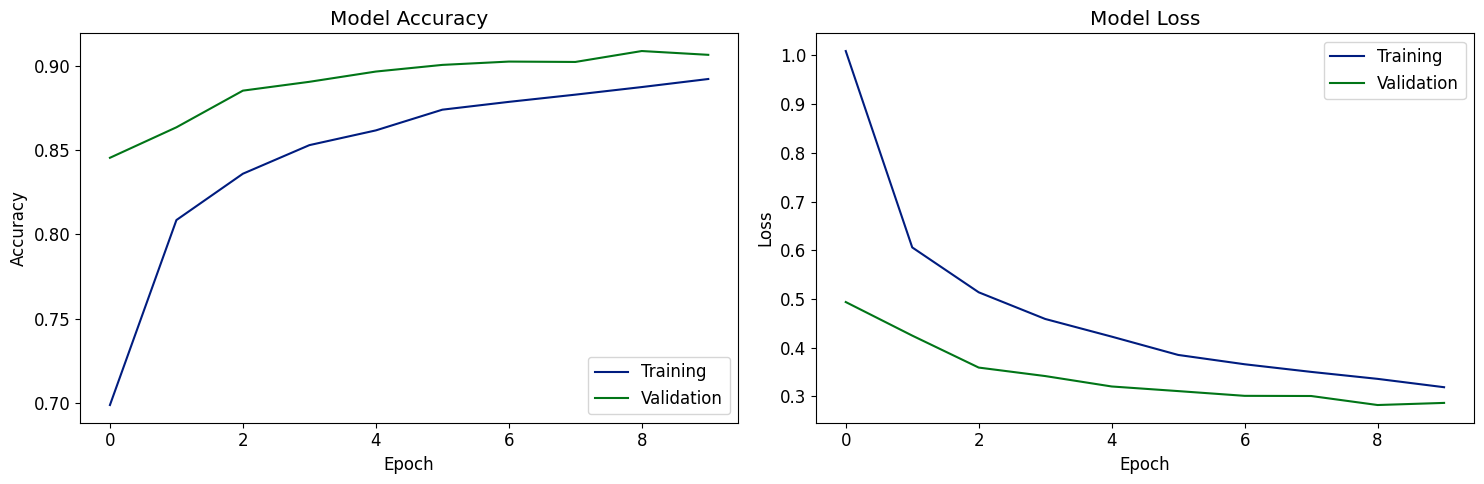

In [ ]:
# model training
# define simpler callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        'models/emnist_classifier.keras',
        save_best_only=True,
        monitor='val_accuracy'
    )
]

# train model with simpler configuration
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=10,  # reduced number of epochs for testing
    batch_size=64,  # increased batch size
    callbacks=callbacks,
    verbose=1
)

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
ax1.plot(history.history['accuracy'], label='Training')
ax1.plot(history.history['val_accuracy'], label='Validation')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot loss
ax2.plot(history.history['loss'], label='Training')
ax2.plot(history.history['val_loss'], label='Validation')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

463/463 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8938 - loss: 0.3295
Test accuracy: 0.8936
463/463 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Precision: 0.6637
Recall: 0.6537
F1 Score: 0.6581


c:\Users\mihir\OneDrive\Desktop\DataSci223\6-neural-nets-MihirUCSF\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


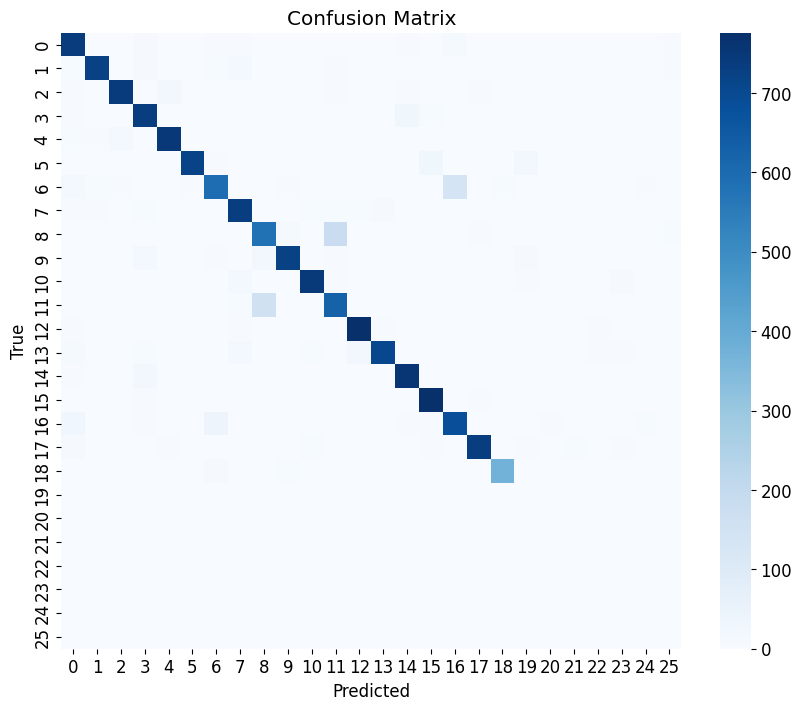

In [8]:
# model evaluation
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

# get predictions
predictions = model.predict(x_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

# calculate metrics
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# calculate confusion matrix
cm = tf.math.confusion_matrix(true_labels, predicted_labels)

# plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, cmap='Blues') 
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# save metrics
metrics = {
    'model': 'emnist_classifier',
    'accuracy': float(test_accuracy),
    'precision': float(precision),
    'recall': float(recall),
    'f1_score': float(f1),
    'confusion_matrix': cm.numpy().tolist()
}

# save to file
with open('results/part_1/emnist_classifier_metrics.txt', 'w') as f:
    f.write(f"model: {metrics['model']}\n")
    f.write(f"accuracy: {metrics['accuracy']}\n")
    f.write(f"precision: {metrics['precision']}\n")
    f.write(f"recall: {metrics['recall']}\n")
    f.write(f"f1_score: {metrics['f1_score']}\n")
    f.write("confusion_matrix: (large matrix omitted)\n")
    f.write("----\n")

## Progress Checkpoints

1. **Data Loading**:
   - [ ] Successfully load EMNIST dataset
   - [ ] Verify data shapes and ranges
   - [ ] Visualize sample images

2. **Preprocessing**:
   - [ ] Normalize pixel values
   - [ ] Reshape data for dense layers
   - [ ] Convert labels to one-hot encoding

3. **Model Implementation**:
   - [ ] Create model with required layers
   - [ ] Verify architecture requirements
   - [ ] Test model with sample input

4. **Training**:
   - [ ] Train model with callbacks
   - [ ] Monitor training progress
   - [ ] Save best model

5. **Evaluation**:
   - [ ] Calculate performance metrics
   - [ ] Save metrics in correct format
   - [ ] Visualize results

## Common Issues and Solutions

1. **Data Loading Issues**:
   - Problem: EMNIST dataset not found
   - Solution: Check internet connection and TensorFlow installation

2. **Preprocessing Issues**:
   - Problem: Shape mismatch in dense layers
   - Solution: Ensure data is properly reshaped to (n_samples, 784)
   - Problem: Label encoding errors
   - Solution: Verify label range and one-hot encoding

3. **Model Issues**:
   - Problem: Training instability
   - Solution: Add batch normalization, reduce learning rate
   - Problem: Overfitting
   - Solution: Increase dropout, use data augmentation

4. **Evaluation Issues**:
   - Problem: Metrics format incorrect
   - Solution: Follow the exact format specified
   - Problem: Performance below threshold
   - Solution: Adjust architecture, hyperparameters